In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px


from IPython.display import display, HTML
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py

import datetime as DT
import hmac
import matplotlib.pyplot as plt
import seaborn as sns
import html5lib
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML

py.init_notebook_mode(connected=True)

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
#load data sets
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sample= pd.read_csv("sample_submission.csv")

In [3]:
store1item1 = train.loc[(train['store'] == 1) & (train['item'] == 1)]
store1item1.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
store1item1['date']  =  pd.to_datetime(store1item1['date'],infer_datetime_format = True)             #convert from string to datetime

indexedDataset2  =  store1item1.set_index(['date'])
indexedDataset2= indexedDataset2.drop(columns=["store","item"])
indexedDataset2.head(5)

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [7]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

In [8]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series, autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:') 
    print(dfoutput)

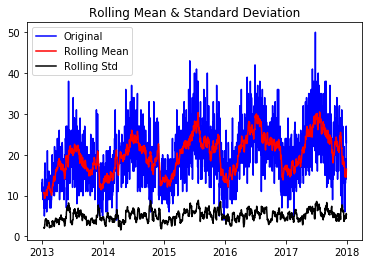

In [9]:
rolling_means(indexedDataset2["sales"])

In [10]:
adf_test(indexedDataset2['sales'])

Results of Dickey Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


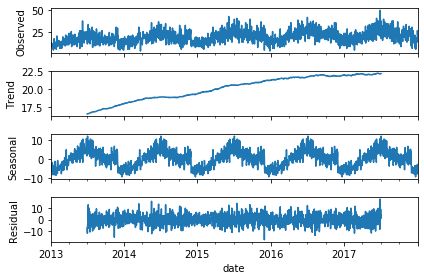

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(indexedDataset2['sales'], model='additive', freq=365).plot()

In [12]:

#log scale transform
import numpy as np
indexedDataset2_logScale  =  np.log(indexedDataset2)

In [13]:
adf_test(indexedDataset2_logScale.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.594424
p-value                           0.005869
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


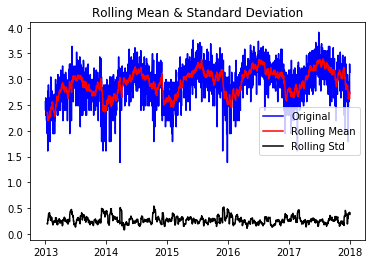

In [14]:

rolling_means(indexedDataset2_logScale)

In [15]:
movingAverage  =  indexedDataset2_logScale.rolling(window = 12).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset2_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)

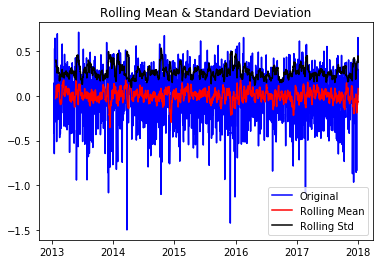

In [16]:
rolling_means(datasetLogScaleMinusMovingAverage)

In [17]:
adf_test(datasetLogScaleMinusMovingAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.031707e+01
p-value                        3.077488e-18
#Lags Used                     2.000000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


In [18]:
exponentialDecayWeightedAverage  =  indexedDataset2_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()

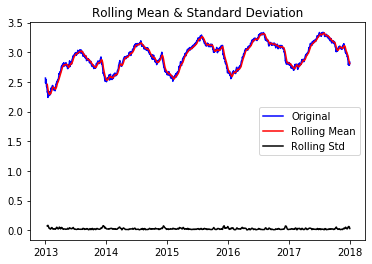

In [19]:
rolling_means(exponentialDecayWeightedAverage)

In [20]:
adf_test(exponentialDecayWeightedAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.666915
p-value                           0.004603
#Lags Used                       24.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


In [21]:
datasetLogDiffShifting  =  indexedDataset2_logScale - indexedDataset2_logScale.shift()

In [22]:
datasetLogDiffShifting.dropna(inplace = True)

In [23]:
adf_test(datasetLogDiffShifting.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.259629e+01
p-value                        1.775858e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


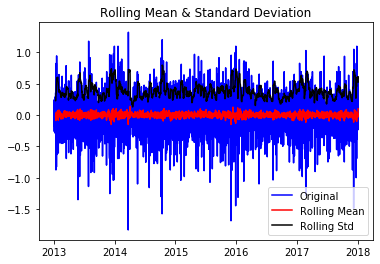

In [24]:

rolling_means(datasetLogDiffShifting)

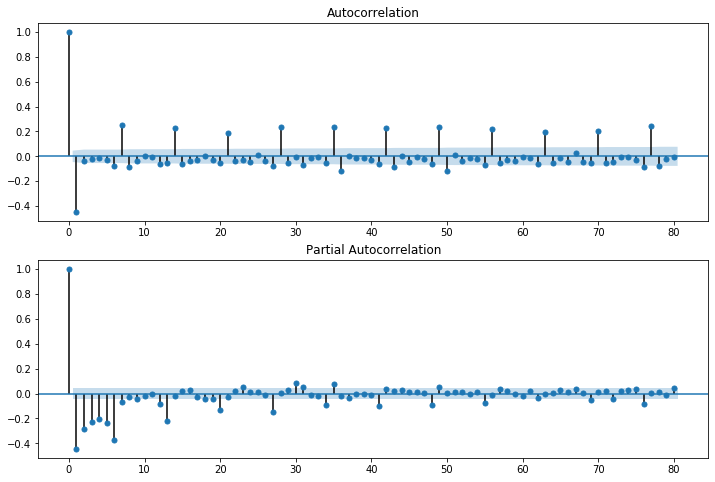

In [25]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(datasetLogDiffShifting.sales, lags=80, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = plot_pacf(datasetLogDiffShifting.sales, lags=80, ax=ax2)

In [26]:
train, test = datasetLogDiffShifting[0:len(datasetLogDiffShifting)-100], datasetLogDiffShifting[len(datasetLogDiffShifting)-100:]
train.head()

,sales
date,
2013-01-02,-0.167054
2013-01-03,0.241162
2013-01-04,-0.074108
2013-01-05,-0.262364
2013-01-06,0.182322


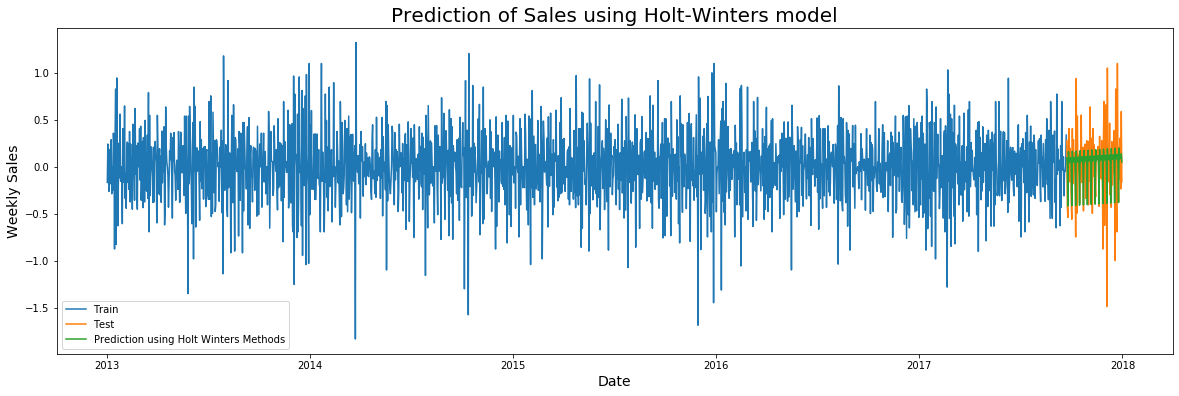

In [27]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(train, seasonal_periods=7, trend='additive', seasonal='additive').fit() 
pred1 = model_holt_winters.forecast(len(test))# Predict the test data
#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Sales using Holt-Winters model', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred1, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test['sales'], pred1))

Mean Squared Error (MSE) of Holt-Winters:  0.13426586447903704


In [29]:
model_holt_winters = ExponentialSmoothing(datasetLogDiffShifting, seasonal_periods=7, trend='additive', seasonal='additive').fit() 
index_future_dates = pd.date_range(start='2017-12-31',end='2018-01-30')
pred=model_holt_winters.predict(start=len(datasetLogDiffShifting),end=len(datasetLogDiffShifting)+30).rename('Holt Winter PREDICTION')
pred.index=index_future_dates

In [30]:
print(pred)

2017-12-31   -0.448028
2018-01-01    0.142494
2018-01-02    0.052953
2018-01-03    0.084602
2018-01-04   -0.014304
2018-01-05    0.224561
2018-01-06    0.025879
2018-01-07   -0.443352
2018-01-08    0.147170
2018-01-09    0.057629
2018-01-10    0.089277
2018-01-11   -0.009628
2018-01-12    0.229236
2018-01-13    0.030554
2018-01-14   -0.438677
2018-01-15    0.151845
2018-01-16    0.062304
2018-01-17    0.093953
2018-01-18   -0.004953
2018-01-19    0.233912
2018-01-20    0.035230
2018-01-21   -0.434002
2018-01-22    0.156521
2018-01-23    0.066980
2018-01-24    0.098628
2018-01-25   -0.000278
2018-01-26    0.238587
2018-01-27    0.039905
2018-01-28   -0.429326
2018-01-29    0.161196
2018-01-30    0.071655
Freq: D, Name: Holt Winter PREDICTION, dtype: float64


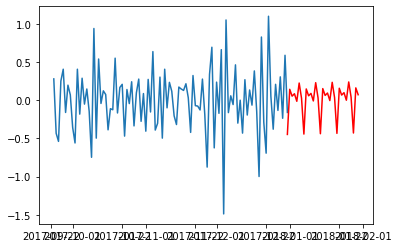

In [31]:
from matplotlib import pyplot
pyplot.plot(test)
pyplot.plot(pred, color='red')
pyplot.show()